In [1]:
import pandas as pd
import numpy as np
import decimal

## Importar arquivo

In [2]:
filename = 'AllWordsOcorrences.csv'
#filename = 'estrutura-esperada.csv'

dados = pd.read_csv(filename, sep=',')
dados.head()

original_dados = dados.copy()

## Tratar palavras

In [3]:
import enchant
from nltk.corpus import stopwords

dictionary_en_US = enchant.Dict("en_US")

columns = [column for column in dados.columns if dictionary_en_US.check(column)]
columns = [column for column in columns if column not in stopwords.words('english')]

#dados = dados.filter(items=columns)
dados.head()

,Sentiment,a,aaa,aadithya,aap,abdul,abhay,able,abnormally,aboarding,...,yummy,yyy,z,zama,zero,zinc,zodiac,zone,zones,zoo
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Separar treino e teste

In [6]:
def separar_treino_teste(proporcao):
    total = len(dados)

    treino = np.random.choice(total, int(total*proporcao), replace=False)
    teste = set(range(total)) - set(treino)

    dados_treino = dados[dados.index.isin(treino)]
    dados_teste = dados[dados.index.isin(teste)]

    return dados_treino, dados_teste

dados, dados_teste = separar_treino_teste(.8)

## Calcular probabilidades (memoização)

In [9]:
P_sentimento = dados.Sentiment.value_counts() / len(dados)
P_sentimento

3    0.722131
2    0.167213
1    0.110656
Name: Sentiment, dtype: float64

In [17]:
def calcular_probabilidade_conjunta(dados, coluna):
    return dados.groupby(coluna).sum() / len(dados)

def calcular_probabilidade_conjunta_palavras_nao_usadas(dados, coluna):
    conjunta = calcular_probabilidade_conjunta(dados, coluna)
    del conjunta[coluna.name]
    return conjunta


class ProbabilidadeConjunta:
    palavra_usada = calcular_probabilidade_conjunta(dados, dados.Sentiment)
    palavra_nao_usada = calcular_probabilidade_conjunta_palavras_nao_usadas(dados == 0, dados.Sentiment)
    
    @staticmethod
    def variavel(variavel):
        P_variavel = ProbabilidadeConjunta.palavra_usada[variavel]
        P_not_variavel = ProbabilidadeConjunta.palavra_nao_usada[variavel]
        
        dataframe = P_variavel.to_frame()
        dataframe.insert(loc=1, column='not {}'.format(variavel), value=P_not_variavel)

        return dataframe

ProbabilidadeConjunta.palavra_usada

,a,aaa,aadithya,aap,abdul,abhay,able,abnormally,aboarding,abode,...,yummy,yyy,z,zama,zero,zinc,zodiac,zone,zones,zoo
Sentiment,,,,,,,,,,,,,,,,,,,,,
1,0.051639,0.0,0.0,0.0,0.0,0.0,0.000820,0.00000,0.00000,0.0,...,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0
2,0.077869,0.0,0.0,0.0,0.0,0.0,0.000820,0.00000,0.00082,0.0,...,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0
3,0.312295,0.0,0.0,0.0,0.0,0.0,0.007377,0.00082,0.00000,0.0,...,0.001639,0.00082,0.0,0.00082,0.0,0.0,0.00082,0.0,0.0,0.0


In [7]:
ProbabilidadeConjunta.variavel('able')

,able,not able
Sentiment,,
1,0.000787,0.102046
2,0.000787,0.177597
3,0.007608,0.711175


In [8]:
ZERO_REPLACEMENT = decimal.Decimal(0.1)

def calcular_probabilidade_condicional(probabilidade_conjunta):
    to_decimal = lambda d: decimal.Decimal(d)

    condicional = probabilidade_conjunta.T / P_sentimento
    condicional = condicional.apply(lambda series: series.apply(to_decimal))
    condicional.replace(to_replace=0, value=ZERO_REPLACEMENT, inplace=True)

    return condicional

class ProbabilidadeCondicional(object):
    palavra_usada     = calcular_probabilidade_condicional(ProbabilidadeConjunta.palavra_usada)
    palavra_nao_usada = calcular_probabilidade_condicional(ProbabilidadeConjunta.palavra_nao_usada)

    @staticmethod
    def variavel(variavel):
        P_variavel     = ProbabilidadeCondicional.palavra_usada.T[variavel]
        P_not_variavel = ProbabilidadeCondicional.palavra_nao_usada.T[variavel]
        
        dataframe = P_variavel.to_frame()
        dataframe.insert(loc=1, column='not {}'.format(variavel), value=P_not_variavel)

        return dataframe


#ProbabilidadeCondicional.palavra_nao_usada.head()
ProbabilidadeCondicional.variavel('able')

,able,not able
1,0.00765306122448979660871648533770894573535770...,0.99234693877551016782945225713774561882019042...
2,0.00441176470588235287995093614199504372663795...,0.99558823529411755171025788513361476361751556...
3,0.01058394160583941631670334970749536296352744...,0.98941605839416046919154723582323640584945678...


## Naive Bayes

In [9]:
def naive_bayes(review, sentimento):
    # P(Sentiment=x)
    resultado = decimal.Decimal(P_sentimento[sentimento])

    # P(palavra | Sentiment=x)
    used_words     = ProbabilidadeCondicional.palavra_usada[sentimento].loc[review == 1]
    not_used_words = ProbabilidadeCondicional.palavra_nao_usada[sentimento].loc[review == 0]
    
    if not used_words.empty:
        resultado *= used_words.product()
    resultado *= not_used_words.product()

    return resultado

In [10]:
def argmax(resultados):
    return resultados[max(resultados.keys())]
    

def testar(dados):
    total_corretos = 0

    for index, row in dados.iterrows():
        esperado = row[0]
        palavras = row[1:]
        
        resultados = {naive_bayes(palavras, sentimento): sentimento for sentimento in [1, 2, 3]}

        if esperado == argmax(resultados):
            total_corretos += 1

    return total_corretos

In [11]:
## Optimize
def naive_bayes_pandas(review):
    used_words     = ProbabilidadeCondicional.palavra_usada.loc[review == 1]
    not_used_words = ProbabilidadeCondicional.palavra_nao_usada.loc[review == 0]
    
    return pd.concat([used_words, not_used_words], ignore_index=True).product()

def naive_bayes_np(review):
    used_words     = ProbabilidadeCondicional.palavra_usada.loc[review == 1].values
    not_used_words = ProbabilidadeCondicional.palavra_nao_usada.loc[review == 0].values

    return tuple(used_words.prod(axis=0) * not_used_words.prod(axis=0))

def testar_pandas(dados):
    return dados.T[1:].apply(naive_bayes_pandas, axis=0)

def testar_pandas2(dados):
    return dados.T[1:].apply(naive_bayes_np, axis=0).apply(pd.Series)

i = 10

#%load_ext line_profiler
%timeit testar(dados.head(i))
%timeit testar_pandas(dados.head(i))
%timeit testar_pandas2(dados.head(i))

114 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
107 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
65.3 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
resultado = testar(dados)

print(resultado)
print(resultado / len(dados))

1347
0.35335781741867783


In [13]:
resultado_teste = testar(dados_teste)

print(resultado_teste)
print(resultado_teste / len(dados_teste))

405
0.42452830188679247


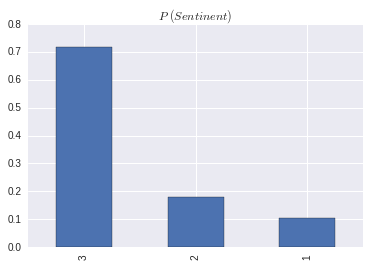

In [14]:
import seaborn as sns
%matplotlib inline

ax = (P_sentimento).plot(kind='bar')
ax.set_title('$P\ (Sentinent)$')